In [ ]:
%load_ext autoreload
%autoreload 2

$L = (\cdot)^2$

$f = sin(x)$

$Lf = sin^2(x)$

# Custom Discretizations

## Intuitive picture

A simulator is an algorithm that finds and represents, using a set of finite numbers, a function of interest $f(x)$. This function is often the (initially unknown) solution of a certain differential equation

\begin{equation}
    (\mathcal{L}f)(x) = g(x).
\end{equation}

The meaning of this equation is the following. Given a function $f \in \mathbf{F}$, the operator $\mathcal{L}: \mathbf{F} \to \mathbf{G}$ maps the function $f$ to a new function $g \in \mathbf{G}$. 

If $\mathbf{F}=\mathbf{G}$, and they are are vector spaces, we can express $f(x)$ and $g(x)$ using a (potentially infinite) set of basis vectors $n_{\eta}(x)$ and represent each function with the parameters of the linear combination. This operation is at the heart of many transforms. As an example, we can associate $\hat f$ with $f$, with

\begin{equation}
    \hat f(\eta) = \langle n_{\eta}(x) | f(x) \rangle.
\end{equation}

The argument can also be used in reverse: given a set of basis function, we define a family of functions as all possible linear combinations of the basis elements.

As a concrete example, let's set the basis vector to the complex exponentials of varying frequency

\begin{equation}
    n_{\eta}(x) = e^{i\eta x}.
\end{equation}

The transformation, or basis change, becomes the standard Fourier transform

\begin{equation}
    \hat f(\eta) = \int f(x) e^{-i\eta x}dx.
\end{equation}

One can also decide to use a finite set of basis vectors to define the family of functions, such that $\hat f \in \mathbb{R}^N$ and the function is simply given by

\begin{equation}
    f(x) = \sum_i \hat f_i n_i(x).
\end{equation}

The fact that we use a finite set of parameters is the key element that allows us to represent the function on a computer. If once again we use a set of complex exponential functions, with regularly spaced frequencies, we obtain the discrete Fourier transform. 

If the operator $\mathcal{L}$ is a linear combination of partial differential operators, assuming that our class of function is closed with respect to differentiation, the operator itself can be written as a finite size matrix $L$, by applying it to each element of the representation of $f$ and expading the result in term of the basis itself:

\begin{equation}
    \mathcal{L} \to L \qquad \text{where } L_{i,j} = \hat f_i \langle  n_j(x) | \mathcal{L} n_i(x) \rangle
\end{equation}

This expression is at the heart of many simulation methods. Transforming the PDE into a matrix-vector product allows to leverage the tools of linear algebra to solve it. However, because a finite set of functions is used, the solution often only approximates the true one. The quality of such approximation depends on how well the choosen discretization, i.e. family of functions, overlaps with range of the operator $\mathcal{L}$.

## Operators are continous function transformations

Many linear discretizations are often realized by sampling the continous space $x$ at a finite set of points $x_i$, called nodes. The function $f$ is then represented as a linear combination of the basis functions, where the coefficients are uniquely determined by the field at the sampling positions $\bar f = [f(x_1), f(x_2), \dots]$ via an invertible transformation $T: \mathbb{R}^N \to \mathbb{R}^N$:

$$
f = \sum_i T_i(\bar f) n_i
$$

The major advantage of such a formulation is that the value of the function at the discretization points can be obtained without any computational cost, just by returning the appropriate element of the $\bar f$. 

The ubiquity of such a representation has also been a source of confusion. Ineed it is often claimed that several discretization methods, such as finite differences or spectral methods, can only accurately represent a field at the discretization points and must rely on interpolation methods to approximate the field away from them. Such picture is further reinforced by the fact that multiple discretization techniques can share the same spatial discretization points, e.g. grid-based methods encompassing spectral and FD, resulting into the basis functions being absorbed by the operator itself, leading to various so-called *operator discretizations*.

While this is technically correct, following the presentation developed so far we can equivalently claim that all discrete representation can intrinsically represent the function exactly at any point, via the synthesis equation

$$
f(x) = \sum_i T_i(\bar f) n_i(x),
$$

even if $f$ represented by its value at a finite set of spatial locations. Wether this function is close to the actual one of interest, only depends on how well the family $\mathbf{F}$ can represent it. The interpolation method is induced by the synthesis equation itself, by expanding the $T_i(\bar f)$ under the assumption that $T$ is linear.

If we take this perspective, then an operator is nothing more than a *transformation* of the algorithm that computes the value of $f(x)$ to one that retuns the value of $g(x)$. This means that to apply an operator to a given family of functions, we can either need to know how to transform the algorithm that computes $f(x)$ into one that computes $g(x)$.

We are talking about function transformations, and that's where JAX shines. Specifically, to differenciate the function $f(x)$ we are looking for the function transformation $f(x) \to \partial_x f(x)$, which is exactly what the `jax.grad` decorator does. Furthermore, if $\mathbf{F}$ is a family of functions parametrized by a set of parameters $\bar f$, then we can leverage `autograd` also to find gradients with respect to the function representation itself.

With this view, differential operators are a property of the family of function under consideration. As a bonus side-effect of this view on operators, one can write complex operators in a way that is agnostic to the underlying representation, and get automatic discretization with respect to any family of functions. Furthermore, we are not restricted to families of functions that are linear with respect to the parameters [[Raissi2019](https://www.sciencedirect.com/science/article/pii/S0021999118307125), [Lu2019](https://arxiv.org/abs/1907.04502)], nor the function parameters need to be given necessarily at some spatial locations.

## `jwave` discretizations

In light of all that has been said so far and to accomodate non-linear function families and operators, the framework used in `jwave` is the following. 

Function families are defined in the `discretization` module. In a nutshell, a function family is an object containing a function $f(\lambda,\theta;x)$ returned by `get_field`: such callable, which is the synthesis function and is written in `jax`, computes the value of the field represented by the parameters $\theta$ at position $x$. It further accepts a [PyTree](https://jax.readthedocs.io/en/latest/pytrees.html) of discretization parameters $\lambda$, that may contain variables such as the stencils for finite differences operators, the frequency grid for Fourier based methods, etc: such parameters are independent of the field value and are common to all functions in a given discretization family.

In [50]:
from jwave.discretization import RealFourierSeries
from jax import random
from jwave.geometry import Domain
import jax

seed = random.PRNGKey(42)

domain = Domain((1024,1024), (.5,.6))
fourier_discretization = RealFourierSeries(domain)

The generated discretization can be used to create a new field. To do so, we just have to define an appropriate set of parameters, or alternatively sample a random field from the discretization itself. We can use the `get_field` method to get the field values

In [51]:
from jax.random import PRNGKey

seed = PRNGKey(30)
u_params = fourier_discretization.random_field(seed)
discr_params = fourier_discretization.params
f = fourier_discretization.get_field()

In [52]:
print(u_params.shape) # Those are the field parameters, i.e. its discrete representation

(1024, 1024)


In [53]:
jax.jit(f)(discr_params, u_params, .5)  # Can be compiled

DeviceArray(-1.2483935, dtype=float32)

In [54]:
print(jax.make_jaxpr(f)(discr_params, u_params, 1.))

{ lambda  ; a b c.
  let d = fft[ fft_lengths=(1024, 1024)
               fft_type=FftType.RFFT ] b
      e = convert_element_type[ new_dtype=float32
                                weak_type=False ] c
      f = mul a e
      g = reduce_sum[ axes=(2,) ] f
      h = convert_element_type[ new_dtype=complex64
                                weak_type=False ] g
      i = mul h 1j
      j = exp i
      k = mul d j
      l = reduce_sum[ axes=(0, 1) ] k
      _ = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(1,) ] 0
      m = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(1024, 0, 2) ] 0.0
      _ = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(1,) ] 0
      n = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(1024, 0) ] 0j
      o = conj[ input_dtype=complex64 ] n
      p = convert_element_type[ new_dtype=float32
                                weak_type=False ] c
 

The values on a grid defined over the domain can be obtained using the method `get_field_on_grid` of the discretization family. This reduces the computational complexity of getting values on a grid for some families, such as the `FourierSeries` case; if undefined, it simply parallelizes the execution of the `get_field` method with `vmap`.
The signature of the function is `f(discr_parameters, field_parameters) -> values_on_grid` and doesn't depend on `x`.

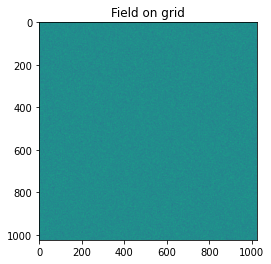

In [55]:
f_grid = fourier_discretization.get_field_on_grid()
grid_values = f_grid(discr_params, u_params)

# Showing field
from matplotlib import pyplot as plt
plt.imshow(grid_values)
plt.title("Field on grid")
plt.show()

Because the user is free to define any method on a discretization, the `get_field_on_grid` is much simpler than `get_field` for grid-based discretizations

In [56]:
print(jax.make_jaxpr(f_grid)(discr_params, u_params))

{ lambda  ; a b.
  let 
  in (b,) }


## Implementation of operators

Starting with our function $f(x) = F_\lambda(x;\theta)$, this function is fully specified given the family $F_\lambda$ and parameters $\theta$. In general, an operator $T$ maps functions to functions. The new function will be given by a new set of parameters $\theta'$, but can also belong to a new family of parameters.

As an example, assume that $f(x) = \theta x$ is our family of functions. The operator $\partial_x$ maps $f$ to $g(x) = \partial_x f(x) = \theta$, which is clearly a different family of functions. Note that this view is different than what is assumed in Finite Element.

If the function is instead parametrized as $f(x) = \theta_1 e^{\theta_2 x}$, then the same operator maps it to $g(x) = \partial_x f(x) = \theta_1\theta_2e^{\theta_2x}$. This new function belongs to the same family of functions, with the parameters transformed as

$$
(\theta_1, \theta_2) \to (\theta_1\theta_2, \theta_2)
$$

To accomodate both those views, and in general to let the user freely choose between quickly experimenting with complex models, or optimize the performance of a specific operator for a specific discretization, an operator is modeled as a function that maps a pair of parameters and function family with a new pair, that is

$$
T(\theta, F) \to (\theta',G)
$$

Binary operators, such as addition `+`, are defined in the same way

$$
B(\theta_1,\theta_2,F_1,F_2) \to (\theta',G)
$$

Note that although this means that binary operations need to be explicitly described for each possible pair of families, we can most often define this in general. Getting back to the addition example, we can always write

\begin{align*}
\theta'& \leftarrow [\theta_1, \theta_2] \\
G(\theta',x) &\leftarrow F_1(\theta'[0],x) + F_2(\theta'[1],x)
\end{align*}

This is the default behaviour that `jwave` discretization follow: if no special method is given, the most general version of the operator is used.

One of the aims of `jwave` is to be fully differentiable. This means that we want to be able to evaluate gradients (with `autograd`) with respect to an arbitrary chain of operators.

In [71]:
from jwave.core import operator
from jax import numpy as jnp
from jwave import operators as jops
from jax import numpy as jnp

Tanh = jops.elementwise(jnp.tanh)

@operator(debug=False)
def custom_op(u,v):
    a = 2*u
    b = a + v
    d = b + u
    e = Tanh(d)
    return u + e

In [72]:
from jwave.core import Field

# Fourier discretization
seeds = random.split(seed, 2)
u_params = fourier_discretization.random_field(seeds[0])
v_params = fourier_discretization.random_field(seeds[1])
u = Field(fourier_discretization, params=u_params, name='u')
v = Field(fourier_discretization, params=v_params, name='u')

# Compiling operator on the given discretization
op = custom_op(u=u, v=v)
print(op)

# Jax function to compute the first field at an arbitrary position x=1.
discr_params = op.discr_params
input_params = {'u': u.params, 'v': v.params}
n_field = op.get_field(0)
n_field = jax.jit(n_field)

value = n_field(discr_params, input_params, x = jnp.array([1.])) # jittable :D
print(value)

DiscretizedOperator :: [RealFourierSeries], ['_nR'] 

 Input fields: ('u', 'v')

Discretization parameters: ('freq_grid',)

Operations:
- _jR: RealFourierSeries <-- mul_scalar ('u',)
- _k5: RealFourierSeries <-- add ('_jR', 'v')
- _l5: RealFourierSeries <-- add ('_k5', 'u')
- _mO: RealFourierSeries <-- elementwise_tanh ('_l5',)
- _nR: RealFourierSeries <-- add ('u', '_mO')

-1.8401498


In [59]:
%timeit n_field(discr_params, input_params, 1.).block_until_ready()

200 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
n_field = op.get_field_on_grid(0)
n_field = jax.jit(n_field)

print(jax.make_jaxpr(n_field)(discr_params, input_params))

{ lambda  ; a b c.
  let d = xla_call[ backend=None
                    call_jaxpr={ lambda  ; a b c.
                                 let d = mul b 2.0
                                     e = add d c
                                     f = add e b
                                     g = tanh f
                                     h = add b g
                                 in (h,) }
                    device=None
                    donated_invars=(False, False, False)
                    inline=False
                    name=wrapped_f ] a b c
  in (d,) }


In [62]:
%timeit n_field(discr_params, input_params).block_until_ready()

52.9 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
from jax import numpy as jnp
from jax.experimental import stax

init_random_params, predict = stax.serial(
    stax.Dense(1024), stax.Relu,
    stax.Dense(1024), stax.Relu,
    stax.Dense(1))

init_params = lambda seed, domain: init_random_params(seed, (1,))[1]


def get_fun(params, x):
    return predict(params, x)[0,0]

params = init_params(seeds[0], None)
get_fun(params, 1.)

DeviceArray(0.00648867, dtype=float32)

In [68]:
# Reusing the operator with a neural network discretization
from jax.experimental import stax
from functools import partial
from jwave.discretization import Arbitrary

init_random_params, predict = stax.serial(
    stax.Dense(128), stax.Relu,
    stax.Dense(128), stax.Relu,
    stax.Dense(1))

init_params = lambda seed, domain: init_random_params(seed, (1,))[1]

def get_fun(discr_params, params, x):
    return predict(params, x)[0,0]

pinn_discretization = Arbitrary(domain, get_fun, init_params)

u_params = pinn_discretization.random_field(seeds[0])
v_params = pinn_discretization.random_field(seeds[1])    

u = Field(pinn_discretization, params=u_params, name='u')
v = Field(pinn_discretization, params=v_params, name='u')

@operator(debug=True)
def custom_op(u,v):
    a = u+v
    return Tanh(u*a)+2

op = custom_op(u=u, v=v)
print(op)

# Jax function to compute the first field at an arbitrary position x=1.
discr_params = op.discr_params
input_params = {'u': u.params, 'v': v.params}
n_field = op.get_field(0)

value = n_field(discr_params, input_params, 1.)
print(value)

Sorted graph for _mO:
{'_jR', '_mO', '_l5', 'u', 'v', '_k5'}

DiscretizedOperator :: [Arbitrary], ['_mO'] 

 Input fields: ('u', 'v')

Discretization parameters: ('coordinate_grid',)

Operations:
- _jR: Arbitrary <-- join ('u', 'v')
- _k5: Arbitrary <-- join ('u', '_jR')
- _l5: Arbitrary <-- identity ('_k5',)
- _mO: Arbitrary <-- identity ('_l5',)

2.0138493


In [69]:
n_field = jax.jit(op.get_field(0))

In [70]:
%timeit n_field(discr_params, input_params, 1.).block_until_ready()

57.6 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
